# Exploratory Data Analysis (EDA) and Leakage Audit


---

While evaluating my fine-tuned essay scoring model, I noticed an unusually high `test accuracy (≈ 90%)` compared to `validation (≈ 70%)`.
Upon investigation, I found that roughly one-third of the test set essays were exact duplicates of training data — both in topic and content.

This indicated a critical case of **`data leakage`**, meaning the model had effectively been re-evaluated on data it had already “seen” during training.

To address this issue, I:

* Performed text similarity analysis using sentence embeddings

* Removed exact and semantic duplicates within and across data splits to ensure a fair evaluation

* Re-trained the model and observed a lower test score, but one that more accurately reflected true generalisation

**High performance is meaningless without dataset integrity.**
This process underscores the importance of rigorous data auditing and quality control.



## **0. Setup**


---



In [ ]:
!pip install -q transformers datasets evaluate scikit-learn accelerate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, Trainer, TrainingArguments, AutoTokenizer, DataCollatorWithPadding
import os, re, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from datasets import Dataset, DatasetDict
from textwrap import shorten
import seaborn as sns

## **1. Loading & Cleaning Datasets**

---


The **IELTS Writing Task 2 Evaluation dataset (from Hugging Face)** is used, which includes a total of 10,324 essays, with columns for the prompt, essay text, comments, and band score. As the author noted, the comments were generated by GPT models and were therefore excluded from post-training.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load directly from Google Drive
train_path = '/content/drive/MyDrive/train.csv'
test_path  = '/content/drive/MyDrive/test.csv'

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

Mounted at /content/drive


In [ ]:
# Clean 'band'
for df in (df_train, df_test):
    df['band'] = (df['band'].astype(str)
                  .str.replace(r'[\n\r]+', '', regex=True)
                  .str.strip())

# Remove 'evaluation', rename 'prompt'->'topic'
df_clean_train = df_train.drop(columns=['evaluation']).rename(columns={'prompt': 'topic'})
df_clean_test  = df_test.drop(columns=['evaluation']).rename(columns={'prompt': 'topic'})

# Replace "<4" with "3.5", cast to float, compress ints
for df in (df_clean_train, df_clean_test):
    df['band'] = df['band'].replace('<4', '3.5').astype(float)
    df['band'] = df['band'].apply(lambda x: int(x) if float(x).is_integer() else x)

# Label mapping (use union to keep ids stable)
unique_bands = sorted(pd.concat([df_clean_train['band'], df_clean_test['band']]).unique())
band_to_id = {b:i for i,b in enumerate(unique_bands)}
id_to_band = {i:b for b,i in band_to_id.items()}

df_clean_train['label'] = df_clean_train['band'].map(band_to_id).astype(int)
df_clean_test['label']  = df_clean_test['band'].map(band_to_id).astype(int)

print("Bands → ids:", band_to_id)

Bands → ids: {np.float64(3.5): 0, np.float64(4.0): 1, np.float64(4.5): 2, np.float64(5.0): 3, np.float64(5.5): 4, np.float64(6.0): 5, np.float64(6.5): 6, np.float64(7.0): 7, np.float64(7.5): 8, np.float64(8.0): 9, np.float64(8.5): 10, np.float64(9.0): 11}


## **2. Exploratory Data Analysis (EDA)**

---


* Distribution of Band Scores

* Distribution of Essay Lengths

* Essay Length by Band Score

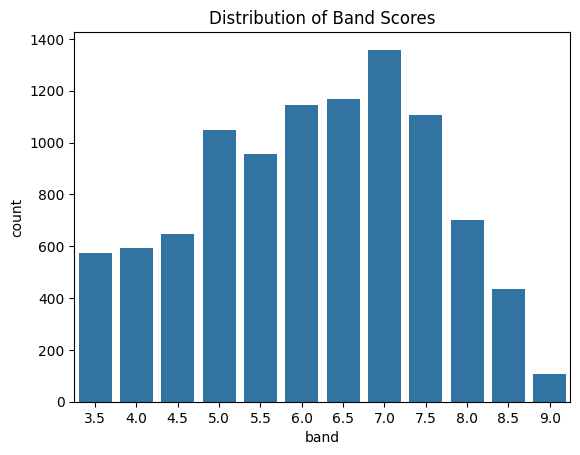

In [ ]:
sns.countplot(x='band', data=df_clean_train, order=sorted(df_clean_train['band'].unique()))
plt.title('Distribution of Band Scores')
plt.show()

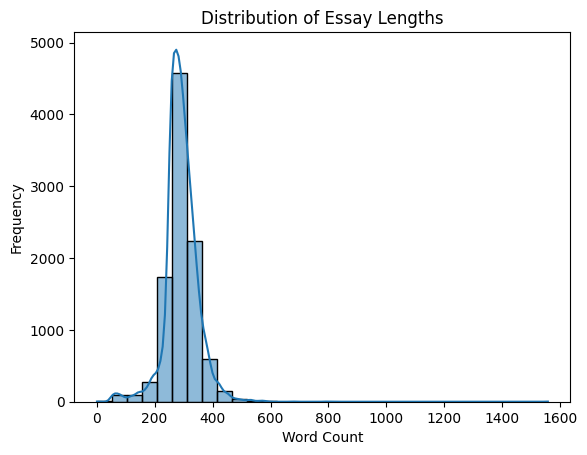

In [ ]:
df_clean_train['essay_length'] = df_clean_train['essay'].apply(lambda x: len(x.split()))
sns.histplot(df_clean_train['essay_length'], bins=30, kde=True)
plt.title('Distribution of Essay Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

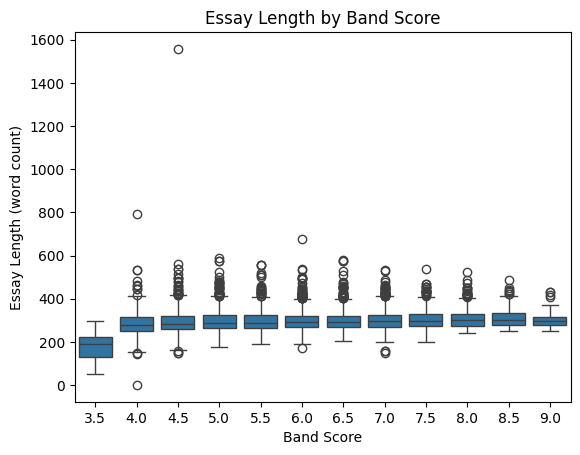

In [ ]:
sns.boxplot(x='band', y='essay_length', data=df_clean_train, order=sorted(df_clean_train['band'].unique()))
plt.title('Essay Length by Band Score')
plt.xlabel('Band Score')
plt.ylabel('Essay Length (word count)')
plt.show()


## **3. Leakeage Audit**

---
Before model training, it is crucial to verify that **no essays (or near-duplicates) appear in both training and testing sets.**
Otherwise, the model may “memorize” essays it later encounters in evaluation, resulting in inflated performance and poor generalisation.

**Two complementary approaches** were considered for detecting potential data leakage under the same essay topic.

### 3.1. Exact Duplicates of Topics

Detect essays that are textually identical (after normalization) within or across splits. This step checks for identical (topic, essay) pairs that appear more than once — either within a single split (train/test) or across both splits.

**Identified:**

* Intra-train exact duplicates

* Intra-test exact duplicates

* Cross train↔test exact duplicates (both sides)

In [ ]:
def normalize_text(s: str) -> str:
    s = str(s).lower().strip().replace('\r', ' ').replace('\n', ' ')
    return ' '.join(s.split())

# Apply the same function to both columns
df_clean_train['topic_norm'] = df_clean_train['topic'].apply(normalize_text)
df_clean_test['topic_norm']  = df_clean_test['topic'].apply(normalize_text)

df_clean_train['essay_norm'] = df_clean_train['essay'].apply(normalize_text)
df_clean_test['essay_norm']  = df_clean_test['essay'].apply(normalize_text)

In [ ]:
# Intra exact (topic, essay)
dup_exact_train_idx = set(df_clean_train.index[
    df_clean_train.duplicated(['topic_norm','essay_norm'], keep='first')
])
dup_exact_test_idx  = set(df_clean_test.index[
    df_clean_test.duplicated(['topic_norm','essay_norm'], keep='first')
])

# Cross exact (drop both sides)
exact_cross = (
    df_clean_train[['topic_norm','essay_norm']].reset_index()
      .merge(df_clean_test[['topic_norm','essay_norm']].reset_index(),
             on=['topic_norm','essay_norm'], suffixes=('_train','_test'))
)

dup_exact_cross_train_idx = set(exact_cross['index_train'])
dup_exact_cross_test_idx  = set(exact_cross['index_test'])

print(f"# exact intra — train:{len(dup_exact_train_idx)} | test:{len(dup_exact_test_idx)}")
print(f"# exact cross pairs: {len(exact_cross)}")


# exact intra — train:1043 | test:4
# exact cross pairs: 611


### 3.2. Near-Duplicate Essays (Semantic) within Topics

**Nevertheless, the prior approach only catches exact textual duplicates, not paraphrases or near-identical rephrasings.** To address this limitation, this method employs **word embedding**–based similarity to capture semantic duplicates — essays that are not exactly identical but convey highly similar meanings (e.g., minor edits, paraphrases, or lexical substitutions) under the same topic.
By comparing essays in an embedding space rather than raw text, this approach ensures that even reworded essays do not leak across splits.


**Identified:**

* Intra-train near-duplicate pairs (same topic)

* Intra-test near-duplicate pairs (same topic)

* Cross train↔test near-duplicates (same topic; both sides dropped)


**Result:**
* Detected more potential leakage cases in the training sets (from **1,043** to **1,223**), indicating that several essays were semantically duplicated but not textually identical.

In [ ]:
THRESH   = 0.99998
MODEL_ID = 'all-MiniLM-L6-v2' # Sentence-transformers model from Hugging Face
DEVICE   = 'cuda' # Use GPU
model = SentenceTransformer(MODEL_ID, device=DEVICE)

def embed(texts):
    return model.encode(list(texts), batch_size=64, convert_to_tensor=True,
                        normalize_embeddings=True, device=DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topics_all = sorted(set(df_clean_train['topic_norm']).union(df_clean_test['topic_norm']))

intra_train_pairs = []   # (i, j) within train
intra_test_pairs  = []   # (i, j) within test
cross_train_idx   = set()
cross_test_idx    = set()

for t in topics_all:
    tr = df_clean_train[df_clean_train['topic_norm'] == t]
    te = df_clean_test [df_clean_test ['topic_norm'] == t]
    if len(tr) + len(te) < 2:
        continue

    # Build one block per topic
    block = []
    if len(tr): block.append(tr[['essay_norm']].assign(src='train', idx=tr.index))
    if len(te): block.append(te[['essay_norm']].assign(src='test',  idx=te.index))
    df_t = pd.concat(block, axis=0).reset_index(drop=True)

    emb = embed(df_t['essay_norm'])
    mined = util.paraphrase_mining_embeddings(
        emb, score_function=util.cos_sim,
        query_chunk_size=1024, corpus_chunk_size=1024
    )

    for score, i, j in mined:
        if score < THRESH:
            break
        si, sj = df_t.at[i, 'src'], df_t.at[j, 'src']
        ii, jj = int(df_t.at[i, 'idx']), int(df_t.at[j, 'idx'])

        if si == 'train' and sj == 'train':
            intra_train_pairs.append((ii, jj))
        elif si == 'test' and sj == 'test':
            intra_test_pairs.append((ii, jj))
        else:
            # drop both sides
            if si == 'train':
                cross_train_idx.add(ii); cross_test_idx.add(jj)
            else:
                cross_train_idx.add(jj); cross_test_idx.add(ii)

    del emb
    if torch.cuda.is_available(): torch.cuda.empty_cache()

print(f"# near intra pairs — train:{len(intra_train_pairs)} | test:{len(intra_test_pairs)}")
print(f"# near cross pairs (both dropped): {len(cross_train_idx)}")

# near intra pairs — train:1223 | test:4
# near cross pairs (both dropped): 605


### 3.3. Apply a Simple Drop Policy

Based on the leakage cases identified through word embedding–based similarity (Section 3.2), a simple yet conservative policy was applied to ensure data integrity while maintaining test-set stability.

**Drop Policy**
* Drop all essays participating in an intra-pair (both members)
* Drop only the training side for all cross-pairs to prevent forward leakage

This guarantees that the model never encountered any essay or its paraphrased variant from the test set during training, while preserving the test set for consistent evaluation.

In [ ]:
# Intra-pair → drop both members
drop_intra_train = set([i for i, j in intra_train_pairs] + [j for i, j in intra_train_pairs])
drop_intra_test  = set([i for i, j in intra_test_pairs]  + [j for i, j in intra_test_pairs])

drop_train = (dup_exact_train_idx
              | dup_exact_cross_train_idx
              | drop_intra_train
              | cross_train_idx)

drop_test = (dup_exact_test_idx
              | drop_intra_test) # Do not drop cross-pair as it's already deleted in training set

df_train_dedup = df_clean_train.drop(index=drop_train).reset_index(drop=True)
df_test_dedup  = df_clean_test.drop(index=drop_test).reset_index(drop=True)

print(f"Total drop — TRAIN:{len(drop_train)} | TEST:{len(drop_test)}")
print(f"Post-dedup sizes — Train:{len(df_train_dedup)} | Test:{len(df_test_dedup)}")

Total drop — TRAIN:1539 | TEST:8
Post-dedup sizes — Train:8294 | Test:483


### 3.4. Sanity Check

Quick audit pass at 0.999 to confirm no obvious duplicates remain.

In [ ]:
def scan_cross(df_tr, df_te, topics, thresh=0.999):
    rows = 0
    for t in topics:
        ttr = df_tr[df_tr['topic_norm']==t]; tte = df_te[df_te['topic_norm']==t]
        if len(ttr)==0 or len(tte)==0:
            continue
        e1 = embed(ttr['essay_norm']); e2 = embed(tte['essay_norm'])
        sim = torch.matmul(e1, e2.T)
        rows += (sim >= thresh).sum().item()
        del e1, e2, sim
        if torch.cuda.is_available(): torch.cuda.empty_cache()
    return rows

remaining = scan_cross(df_train_dedup, df_test_dedup, topics_all, thresh=0.999)
print(f"Remaining cross duplicates (cos ≥ 0.999): {remaining}")

Remaining cross duplicates (cos ≥ 0.999): 1


## **4. Re-Split Train / Test**

---

After deduplication, a split is conducted.

In [ ]:
# Combine all deduplicated essays (shuffle once for safety)
df_all = pd.concat([df_train_dedup, df_test_dedup], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

stratify_col = None

# Random 90/10 split
df_train, df_test = train_test_split(
    df_all,
    test_size=0.1,
    random_state=42,
    shuffle=True,
    stratify=stratify_col
)

# Reset indices
df_train = df_train.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

# Show summary
print(f"Final split complete.")
print(f"Train size: {len(df_train):,} essays")
print(f"Test size:  {len(df_test):,} essays")

if 'band' in df_all.columns:
    print("\nBand distribution check:")
    print("Train:\n", df_train['band'].value_counts(normalize=True).round(3))
    print("\nTest:\n",  df_test['band'].value_counts(normalize=True).round(3))


Final split complete.
Train size: 7,899 essays
Test size:  878 essays

Band distribution check:
Train:
 band
7.0    0.138
6.5    0.120
7.5    0.116
6.0    0.115
5.0    0.103
5.5    0.097
8.0    0.072
4.5    0.066
4.0    0.060
3.5    0.058
8.5    0.044
9.0    0.012
Name: proportion, dtype: float64

Test:
 band
7.0    0.139
5.0    0.133
6.0    0.120
6.5    0.105
7.5    0.104
5.5    0.092
8.0    0.077
4.5    0.068
3.5    0.056
4.0    0.052
8.5    0.046
9.0    0.008
Name: proportion, dtype: float64


## **5. Save as CSV**

---

In [ ]:
output_dir = '/content/drive/MyDrive'
os.makedirs(output_dir, exist_ok=True)

df_train.to_csv(f'{output_dir}/train_ielts4.csv', index=False)
df_test.to_csv(f'{output_dir}/test_ielts4.csv', index=False)

print("Files saved to Google Drive:")
print(f"- {output_dir}/train_ielts4.csv")
print(f"- {output_dir}/test_ielts4.csv")


Files saved to Google Drive:
- /content/drive/MyDrive/train_ielts4.csv
- /content/drive/MyDrive/test_ielts4.csv
